# Is Brl1 a chaperone?

In this notebook, we use the 10-handle KARMA labeling data and combine it with data for Brl1 (which was one of the original 10 handles).
We try to find assembly trees that fit the data, where Brl1 is a unique protein in the sense that it binds and unbinds from the complex at
two different points.

In [1]:
from typing import Tuple
import pandas as pd
from scipy.optimize import curve_fit
from scipy.linalg import expm
import scipy.stats
import os
from tqdm import tqdm
import seaborn as sns
from uncertainties import ufloat, nominal_value, std_dev, unumpy
import numpy as np
import matplotlib.pyplot as plt
import json
import itertools

from karma import RES_DIR, DATA_DIR, AssemblyTree
from karma.fit_pools import load_phis

from matplotlib.backends.backend_pdf import PdfPages
from pynverse import inversefunc

# Set plotting style
sns.set_style("ticks")
from matplotlib import rc
rc('font',**{'family': 'sans-serif'})
rc('text', usetex=False)

NEW_RES_DIR = RES_DIR / "brl1"
if not os.path.exists(NEW_RES_DIR):
    os.mkdir(NEW_RES_DIR)
    
KARMA_10_HANDLE_DATA_FILE = os.path.join(DATA_DIR, "2020-02-01_10Handles_ZZ_K1_NUP_NTR_NTR-like_labeling.tsv")
KARMA_BRL1_DATA_FILES = [
    os.path.join(DATA_DIR, "2021-07-28_BRL1_Timecourse_NUPsNTRs_metabolicLabeling.tsv"),
    os.path.join(DATA_DIR, "2021-08-30_BRL1Labeling_10HandlePD.tsv"),
]


# Step 1: fitting a KSM model to all NUPs (without Brl1 yet)

In [2]:
# we use the result from the previous KARMA assays, asusming that the lysine pool size hasn't changed
LYSINE_PSI = 0.35

CLUSTERS = {
    "MLP1": ["MLP1"],
    "*MLP2": ["MLP2"],
    "NUP1": ["NUP1"],
    "NUP57": ["NUP49", "NUP57"],
    "*NUP53": ["NUP53", "NUP170", "POM152", "POM34"],
    "NUP82": ["NUP82", "NUP159"],
    "NUP84": ["NUP84", "NUP133", "NUP145C"],
    "NUP85": ["NUP85", "NUP120"],
    "NUP188": ["NUP188"],
}



In [3]:
GROWTH_RATE = 0.0078  # 1/min
MIN_PHI = 1e-3
MAX_TIME = 150

def f_target(
    t: np.ndarray,
    phi: np.ndarray,
    index: int,
) -> np.ndarray:
    """
        Calculate the expected target pool (S2) labeling for a protein
        in an exponentially growing cell with growth rate μ.
                
        Arguments:
            t - time (in minutes)
            phi - the parameters of the pools (starting with the precusros pool)
            index - the index of the target pool
    """
    inv_phi = [1.0/p for p in phi.flat]
    M = np.diag(inv_phi[1:], k=1) - np.diag(inv_phi)
    
    if type(t) == float:
        res = expm(M * GROWTH_RATE * t)[:, index].sum()
        return 1.0 - res  # return a float as well
    else:
        res = np.array([expm(M * x)[:, index].sum() for x in (GROWTH_RATE * t).flat])
        return 1.0 - res  # return an array with the same shape as 't'

In [4]:
# internal reference proteins behave as 2-step systems with a phi = LYSINE_PSI,
# so we can use the same function for them
f_timers = lambda t: f_target(t, np.array([LYSINE_PSI, 1]), index=1)
f_timers_inverse = inversefunc(f_timers, domain=[0, MAX_TIME], open_domain=False)

In [5]:
def fit_phis(xdata: np.ndarray, ydata: np.ndarray, inaccessible=True):

    def f_without_inaccessible(tdata: np.ndarray, phi1: float):
        return f_target(tdata, np.array([LYSINE_PSI, phi1, 1]), index=2)
    
    def f_with_inaccessible(tdata: np.ndarray, phi1_phi2: float, z: float = 1.0):
        """
            when z = 0, both phi1 and phi2 are equal (phi1 = phi2 = sqrt(phi1_phi2))
            when z = 1, phi2 will be equal to 1 (phi1 = phi1_phi2)
        """
        phi1 = np.sqrt(phi1_phi2 * (1 - z + z*phi1_phi2))
        phi2 = np.sqrt(phi1_phi2 / (1 - z + z*phi1_phi2))
        return f_target(tdata, np.array([LYSINE_PSI, phi1, phi2]), index=2)

    if inaccessible:
        popt, pcov = curve_fit(f_with_inaccessible, xdata=xdata, ydata=ydata, p0=(0.5, 0.5), bounds=[(MIN_PHI, 0), (1, 1)])
        mse = np.mean( (ydata - f_with_inaccessible(xdata, *popt))**2 )
        phi1 = np.sqrt(popt[0] * (1 - popt[1] + popt[1]*popt[0]))
        phi2 = np.sqrt(popt[0] / (1 - popt[1] + popt[1]*popt[0]))
        phi1_phi2_std = np.sqrt(pcov[0, 0])
        phi1_std = phi1_phi2_std / phi2
        phi2_std = 0.0
    else:
        popt, pcov = curve_fit(f_without_inaccessible, xdata=xdata, ydata=ydata, p0=(0.5), bounds=[MIN_PHI, 1])
        mse = np.mean( (ydata - f_without_inaccessible(xdata, *popt))**2 )
        phi1 = popt[0]
        phi1_std = np.sqrt(pcov[0, 0])
        phi2 = 1.0
        phi2_std = 0.0

    phi = unumpy.uarray([phi1, phi2], [phi1_std, phi2_std])
    return phi, mse

def calculate_phis(data_df: pd.DataFrame) -> Tuple[pd.DataFrame, plt.Figure]:
    n_baits = len(data_df.bait.unique())
    n_preys = len(data_df.prey.unique())
    phi_data = []
    
    with tqdm(total=n_preys*n_baits) as pbar:
        for bait, bgroup_df in data_df.groupby("bait"):
            pbar.set_description(f"Processing bait {bait}")
            for prey, pgroup_df in bgroup_df.groupby("prey"):
                if pgroup_df.k1.mean() > pgroup_df.timer_k1.mean():
                    # fit with an inaccessible pool, i.e. ln(phi2) lower bound is MIN_PHI
                    phi, mse = fit_phis(pgroup_df.t.values, pgroup_df.k1.values, inaccessible=True)
                    phi_data.append((bait, prey, phi[0], phi[1], mse))
                else:
                    # fit without an inaccessible pool, i.e. ln(phi2) lower bound is 1
                    phi, mse = fit_phis(pgroup_df.t.values, pgroup_df.k1.values, inaccessible=False)
                
                    phi_data.append((bait, prey, phi[0], ufloat(1, 0), mse))
                pbar.update(1)

    return pd.DataFrame(data=phi_data,
                        columns=["bait", "prey", "phi1", "phi2", "mse"])

def plot_ksm_fits(data_df: pd.DataFrame, ksm_df: pd.DataFrame, bait: str, prey: str, ax: plt.Axes):
    t_range = np.linspace(0, MAX_TIME, 25)

    group_data_df = data_df.loc[(data_df.bait == bait) & (data_df.prey == prey), :]
    phi1, phi2, mse = ksm_df.set_index(["bait", "prey"]).loc[(bait, prey), :]
    phi_nom = np.array([LYSINE_PSI, phi1.nominal_value, phi2.nominal_value])

    ax.plot(t_range, 1.0 - np.exp(-t_range*GROWTH_RATE), color=sns.xkcd_rgb["windows blue"],
            label=r"$1 - e^{-\mu t}$", linewidth=1, zorder=1)
    ax.plot(t_range, f_timers(t_range), linewidth=1, 
            color=sns.xkcd_rgb["coral"], label="reference", zorder=1)
    for row in group_data_df.itertuples():
        ax.plot([row.t, row.t], [row.k1, row.timer_k1], linewidth=0.5, color=sns.xkcd_rgb["coral"], label=None, zorder=1)

    ax.scatter(x=group_data_df.t,
               y=group_data_df.k1,
               color=sns.xkcd_rgb["amethyst"],
               label=f"prey: {prey}", zorder=2)

    ax.plot(t_range, f_target(t_range, phi_nom, index=2), color=sns.xkcd_rgb["amethyst"], linewidth=2,
            label=f"$\phi_1$ = {phi1:.1g}, $\phi_2$ = {phi2.nominal_value:.1g}", zorder=2)

    ax.set_xlabel("time (min)")
    ax.set_ylabel("$K_1$ labeling")
    ax.legend(fontsize=7, frameon=False)

def plot_all_ksm_fits(figure_fname: str, data_df: pd.DataFrame, ksm_df: pd.DataFrame, n_cols: int=4):
    baits = sorted(data_df.bait.unique())
    preys = sorted(data_df.prey.unique())
    n_rows = int(np.ceil(len(preys)/n_cols))

    with tqdm(total=ksm_df.shape[0]) as pbar:
        with PdfPages(figure_fname) as pdf:
            for bait in baits:
                fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5), sharex="all", sharey="all")
                for ax, prey in zip(axs.flat, preys):
                    pbar.set_description(f"Plotting KSM fits for {bait}-{prey}")
                    plot_ksm_fits(data_df, ksm_df, bait, prey, ax=ax)
                    pbar.update(1)
                fig.suptitle(f"bait: {bait}")
                pdf.savefig(fig)
                plt.close(fig)

In [6]:
def calculate_clustered_labeling_data(_df, clusters):
    timer_df = _df[_df.prey.isin(["KAP95", "MEX67", "KAP123"])].groupby(["bait", "time", "replicate"]).mean()[["k1"]]
    timer_df.rename(columns={"k1": "timer_k1"}, inplace=True)
    timer_df["t"] = timer_df.timer_k1.apply(f_timers_inverse)
    _df = _df[_df.kind != "NTR"]

    # drop the following baits: NSP1, GLE1, NDC1
    _df = _df[~_df.bait.isin(["NSP1", "GLE1", "NDC1"])]

    _df["cluster"] = ""
    for k, v in clusters.items():
        _df.loc[_df.prey.isin(v), "cluster"] = k

    # drop data of preys that are in none of the clusters
    _df = _df[_df.cluster != ""]
    _df.drop("prey", axis=1, inplace=True)
    _df.rename(columns={"cluster": "prey"}, inplace=True)

    # calculate mean and stdev for each cluster-bait pair (and also across the 3
    # replicates at the same time)
    clustered_data_df = _df.groupby(["bait", "prey", "time", "replicate"]).agg(["mean", "std"])[["k1"]]
    clustered_data_df.columns = ["k1", "k1_std"]
    clustered_data_df = clustered_data_df.reset_index().join(timer_df, on=["bait", "time", "replicate"])
    return clustered_data_df


karma_10_handle_df = pd.read_csv(KARMA_10_HANDLE_DATA_FILE, delimiter="\t")
clustered_data_df = calculate_clustered_labeling_data(karma_10_handle_df, CLUSTERS)

In [7]:
# Run the KSM fitting and plot the results
clustered_ksm_df = calculate_phis(clustered_data_df)
figure_fname = NEW_RES_DIR / "clusters_ksm_fits.pdf"
plot_all_ksm_fits(figure_fname, clustered_data_df, clustered_ksm_df, n_cols=3)

Plotting KSM fits for NUP85-NUP85: 100%|██████████| 81/81 [00:07<00:00, 10.49it/s]  


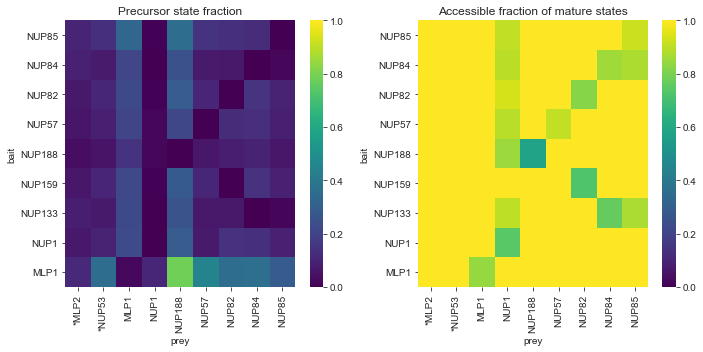

In [8]:
_df = clustered_ksm_df.copy()

DOUBLING_TIME = np.log(2) / GROWTH_RATE
maturation_time = DOUBLING_TIME * _df.phi1 / (1.0 - _df.phi1)
maturation_rate = GROWTH_RATE * (1.0/_df.phi1 - 1.0)

_df["Precursor state fraction"] = _df.phi1.apply(nominal_value)
_df["Precursor state fraction uncertainty"] = _df.phi1.apply(std_dev)
_df["Accessible fraction of mature states"] = _df.phi2.apply(nominal_value)
_df["Maturation time [min]"] = maturation_time.apply(nominal_value)
_df["Maturation time [min] uncertainty"] = maturation_time.apply(std_dev)
_df["Maturation rate [1/min]"] = maturation_rate.apply(nominal_value)
_df["Maturation rate [1/min] uncertainty"] = maturation_rate.apply(std_dev)

_df.drop(["phi1", "phi2", "mse"], axis=1, inplace=True)
_df.round(4).to_csv(NEW_RES_DIR / "clusters_ksm_fits.csv", index=None)

# plot a heatmap of all fits
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vmin = 0
for ax, col in zip(axs.flat, ["Precursor state fraction", "Accessible fraction of mature states"]):
    pivot_df = _df.pivot("bait", "prey", col)
    sns.heatmap(pivot_df, ax=ax, cmap="viridis", vmin=0, vmax=1)
    ax.set_ylim(0, pivot_df.shape[0])
    ax.set_title(col)

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "clusters_ksm_heatmap.svg")

# Step 2: Adding Brl1 as a bait

In [30]:
CLUSTERS_WITH_BRL1 = {
    "MLP1": ["MLP1"],
    "*MLP2": ["MLP2"],
    "NUP1": ["NUP1"],
    "NUP57": ["NUP49", "NUP57"],
    "*NUP53": ["NUP53", "NUP170", "POM152", "POM34"],
    "NUP82": ["NUP82", "NUP159"],
    "NUP84": ["NUP84", "NUP133", "NUP145C"],
    "NUP85": ["NUP85", "NUP120"],
    "NUP188": ["NUP188"],
    "BRL1": ["BRL1"],
}


In [31]:
karma_combined_df = pd.concat([karma_10_handle_df] + [
    pd.read_csv(fname, delimiter="\t") for fname in KARMA_BRL1_DATA_FILES
])
clustered_data_df = calculate_clustered_labeling_data(karma_combined_df, CLUSTERS_WITH_BRL1)

In [11]:
clustered_data_df = clustered_data_df[clustered_data_df.bait != "NUP159"]
#clustered_data_df = clustered_data_df[clustered_data_df.bait != "NUP82"]

In [12]:
# Run the KSM fitting and plot the results
clustered_ksm_df = calculate_phis(clustered_data_df)
figure_fname = NEW_RES_DIR / "clusters_ksm_fits_with_Brl1.pdf"
plot_all_ksm_fits(figure_fname, clustered_data_df, clustered_ksm_df, n_cols=3)

Plotting KSM fits for NUP85-NUP85: 100%|██████████| 81/81 [00:07<00:00, 10.15it/s]  


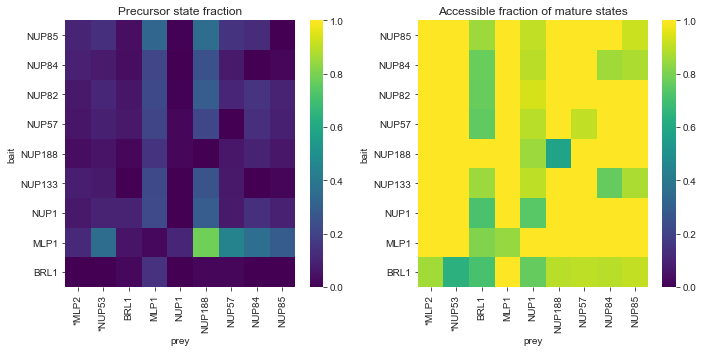

In [13]:
_df = clustered_ksm_df.copy()

DOUBLING_TIME = np.log(2) / GROWTH_RATE
maturation_time = DOUBLING_TIME * _df.phi1 / (1.0 - _df.phi1)
maturation_rate = GROWTH_RATE * (1.0/_df.phi1 - 1.0)

_df["Precursor state fraction"] = _df.phi1.apply(nominal_value)
_df["Precursor state fraction uncertainty"] = _df.phi1.apply(std_dev)
_df["Accessible fraction of mature states"] = _df.phi2.apply(nominal_value)
_df["Maturation time [min]"] = maturation_time.apply(nominal_value)
_df["Maturation time [min] uncertainty"] = maturation_time.apply(std_dev)
_df["Maturation rate [1/min]"] = maturation_rate.apply(nominal_value)
_df["Maturation rate [1/min] uncertainty"] = maturation_rate.apply(std_dev)

_df.drop(["phi1", "phi2", "mse"], axis=1, inplace=True)
_df.round(4).to_csv(NEW_RES_DIR / "clusters_ksm_fits_with_Brl1.csv", index=None)

# plot a heatmap of all fits
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vmin = 0
for ax, col in zip(axs.flat, ["Precursor state fraction", "Accessible fraction of mature states"]):
    pivot_df = _df.pivot("bait", "prey", col)
    sns.heatmap(pivot_df, ax=ax, cmap="viridis", vmin=0, vmax=1)
    ax.set_ylim(0, pivot_df.shape[0])
    ax.set_title(col)

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "clusters_ksm_heatmap_with_Brl1.svg")

On a multicore server, run the following script:

`python -m script.1_fit_poolsizes -j <num_cpus> res/brl1/clusters_ksm_fits_with_Brl1.csv`

This will generate a result file called `res/all_trees_<DATE>_<TIME>.json.gz`

Then run:
`python -m script.2_prune_trees all_trees_<DATE>_<TIME>`

This will generate a result file called `res/all_trees_<DATE>_<TIME>_top_<N_TOP_TREES>.json`

Copy the result to the `res/brl1` folder in your local computer (where you are running this notebook)
and change the `TREE_JSON_FNAME` accordingly.

In [14]:
# loading results from parallel run


TREE_JSON_FNAME = NEW_RES_DIR / "all_trees_2021-08-31_08:33:17_top_2027.json"  # with Brl1, psi = 0.35 (without NUP82 and NUP159)

#TREE_JSON_FNAME = NEW_RES_DIR / "all_trees_2021-09-03_01:48:21_top_2027.json"  # control: all Brl1-pairs assumed to have an empty precursor pool = 0.

with open(TREE_JSON_FNAME, "r") as fp:
    res_json = json.load(fp)

In [15]:
phi_df, preys, baits = load_phis(NEW_RES_DIR / "clusters_ksm_fits_with_Brl1.csv")

level_stats = []
maturation_time_stats = []
for tree_json in res_json["trees"]:
    tree = AssemblyTree.from_json(tree_json["assembly_tree"])
    tree.set_reference_phis(phi_df)
    level_stats.append(tree.get_levels())
    maturation_time_stats.append(tree.get_maturation_times())

level_df = pd.DataFrame(data=level_stats)
mtime_df = pd.DataFrame(data=maturation_time_stats)

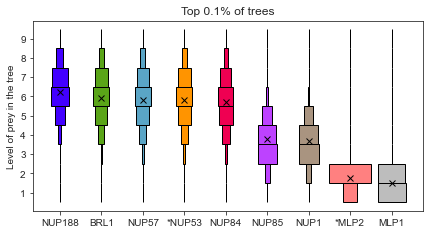

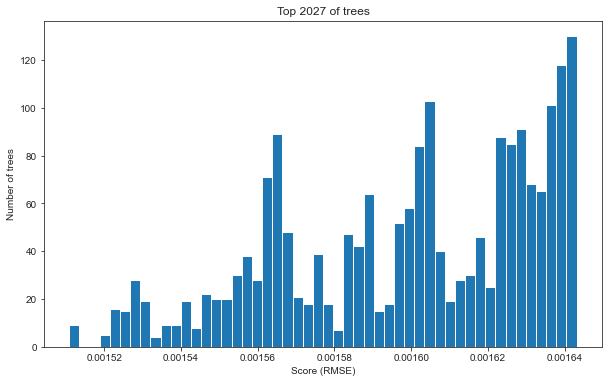

40it [00:01, 20.58it/s]                      


In [16]:
from matplotlib import rc
rc('font',**{'family': 'sans-serif'})
rc('text', usetex=False)

colormap = {"NUP85": "#bd42ff",
            "NUP84": "#ef0052",
            "NUP145C": "#ef0052",
            "NUP133": "#ef0052",
            "*NUP53": "#ff9400",
            #"NUP82": "#5aa518",
            #"NUP159": "#5aa518",
            "NUP57": "#5aa5c6",
            "NUP49": "#5aa5c6",
            "NUP188": "#4200ff",
            "MLP1": "#bdbdbd",
            "*MLP2": "#ff8080",
            "NUP1": "#a99480",
            "BRL1": "#5aa518",
           }

# Generate a single PDF file with all 0.1% top trees (in batches of 40=8x5 per page)
with PdfPages(NEW_RES_DIR / "top_permille_graphs.pdf") as pdf:

    fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
    hist_range = (0, len(preys)+1)
    number_of_bins = len(preys)+1
    binned_data_sets = []

    prey_order = level_df.mean().sort_values(ascending=False).index.tolist()

    for prey in prey_order:
        levels = level_df[prey]
        binned_data_sets.append(np.histogram(levels, range=hist_range, bins=number_of_bins)[0])

    binned_maximums = np.max(binned_data_sets, axis=1)
    x_locations = np.arange(0, len(binned_data_sets)) * np.max(binned_maximums)

    # The bin_edges are the same for all of the histograms
    bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
    centers = 0.5 * (bin_edges + np.roll(bin_edges, 1))[:-1]
    heights = np.diff(bin_edges)

    for x_loc, binned_data, prey in zip(x_locations, binned_data_sets, prey_order):
        lefts = x_loc - 0.5 * binned_data
        ax.barh(0.5+centers, binned_data, height=heights, left=lefts, color=colormap[prey],
                linewidth=1, edgecolor="k")
        ax.plot(x_loc, level_df[prey].mean(), 'kx')

    ax.set_xticks(x_locations)
    ax.set_xticklabels(prey_order)
    ax.set_yticks(range(1, 10))
    ax.set_title("Top 0.1% of trees")
    ax.set_ylabel("Level of prey in the tree")
    ax.set_xlim(-1000, None)
    
    display(fig)
    fig.savefig(NEW_RES_DIR / "tree_level_histogram.pdf")
    pdf.savefig(fig)
    plt.close(fig)
    
    # Plot histogram of all top scores
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    all_scores = [tree_json["score"] for tree_json in res_json["trees"]]
    ax.hist(all_scores, bins=50)
    ax.set_title(f"Top {len(all_scores)} of trees")
    ax.set_xlabel("Score (RMSE)")
    ax.set_ylabel("Number of trees")

    display(fig)
    fig.savefig(NEW_RES_DIR / "tree_score_histogram.pdf")
    pdf.savefig(fig)
    plt.close(fig)
    
    # Plot graphs for all the top trees
    n_trees = 3#len(res_json["trees"])
    n_cols = 5
    n_rows = 8
    with tqdm(total=n_trees) as pbar:
        for i in np.arange(0, n_trees, n_cols*n_rows):
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*6))

            for ax, tree_json in zip(axs.flat, res_json["trees"][i:]):
                tree = AssemblyTree.from_json(tree_json["assembly_tree"])
                tree.plot_tree(ax=ax)
                ax.set_title(f"score = {tree_json['score']:.6f}")
                pbar.update(1)
            pdf.savefig(fig)
            plt.close(fig)

## Generate more statistics using the top 0.1% of trees

In [17]:
tiers = [
    ["NUP57", "NUP84", "*NUP53", "NUP188", "BRL1"],
    ["NUP1", "NUP85", "NUP82"],
    ["MLP1", "*MLP2"],
]

df = pd.read_csv(NEW_RES_DIR / "clusters_ksm_fits_with_Brl1.csv")

tier_mat_times_data = []
for i1, tier1 in enumerate(tiers):
    for i2, tier2 in enumerate(tiers):
        if i1 == i2+1:
            _df = df[df.bait.isin(tier1) & df.prey.isin(tier2)]
            medi = _df["Maturation time [min]"].median()
            mini = _df.groupby("prey").min()["Maturation time [min]"].median()
            tier_mat_times_data.append((i1, i2, medi, mini))

# estimate the maturation time for MLP1 as the final step in the NPC biogenesis
# by taking the median value across all baits (that are not MLP1).
# since MLP1 is the last protein to join the complex, the maturation time
# should not depend on the bait.

t_mlp1 = df.loc[(df.bait != "MLP1") & (df.prey == "MLP1"), "Maturation time [min]"].median()
tier_mat_times_data.append((2, 2, t_mlp1, t_mlp1))
tier_mat_times_df = pd.DataFrame(data=tier_mat_times_data, columns=["bait tier", "prey tier", "median", "minimum"])

In [18]:
for _, row in tier_mat_times_df.iterrows():
    print(f"Estimated maturation time for step {row['prey tier']+1:.0f}: {row['minimum']:.1f} - {row['median']:.1f} minutes")

Estimated maturation time for step 1: 9.4 - 12.6 minutes
Estimated maturation time for step 2: 23.4 - 23.4 minutes
Estimated maturation time for step 3: 24.3 - 24.3 minutes


<AxesSubplot:xlabel='prey2', ylabel='prey1'>

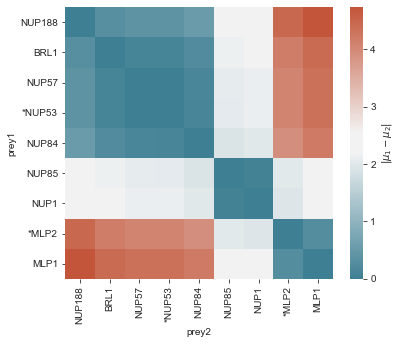

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
diff_data = []
for col1 in prey_order:
    for col2 in prey_order:
        diff_data.append((col1, col2, (level_df[col1] - level_df[col2]).mean()))
diff_df = pd.DataFrame(data=diff_data, columns=["prey1", "prey2", "mean-dist"])
diff_df = diff_df.pivot("prey1", "prey2", "mean-dist")
diff_df = diff_df.loc[prey_order, :]
diff_df = diff_df.loc[:, prey_order]

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(np.abs(diff_df), cmap=cmap, cbar_kws={"label": r"$|\mu_1 - \mu_2|$"}, ax=ax)

<AxesSubplot:>

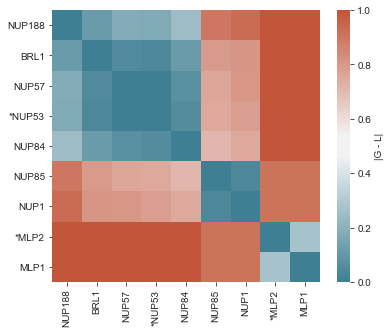

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# heatmap based on |G-L|, i.e. the fraction of times level1 > level2 minus the fraction of times level2 > level1
prey_order = level_df.mean().sort_values(ascending=False).index.tolist()
df = pd.DataFrame(columns=prey_order, index=prey_order, dtype=float)
for prey1, prey2 in itertools.product(prey_order, prey_order):
    levels1 = level_df.loc[0:, prey1]
    levels2 = level_df.loc[0:, prey2]
    df.at[prey1, prey2] = ((levels1 < levels2).sum() - (levels1 > levels2).sum()) / level_df.shape[0]

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(np.abs(df), cmap=cmap, cbar_kws={"label": "|G - L|"}, ax=ax)

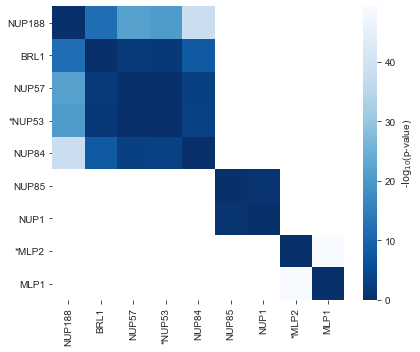

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# calculate p-value of pairwise ranksum tests for the tree-level histograms
prey_order = level_df.mean().sort_values(ascending=False).index.tolist()
df = pd.DataFrame(columns=prey_order, index=prey_order, dtype=float)
for prey1, prey2 in itertools.product(prey_order, prey_order):
    if prey1 == prey2:
        df.at[prey1, prey2] = 1
    else:
        levels1 = level_df[prey1]
        levels2 = level_df[prey2]
        pval = scipy.stats.ranksums(levels1, levels2).pvalue
        if pval < 1e-300:
            df.at[prey1, prey2] = np.nan
        else:
            df.at[prey1, prey2] = pval
sns.heatmap(-np.log10(df), cmap="Blues_r", cbar_kws={"label": r"-$\log_{10}$(p-value)"}, ax=ax)

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "tree_level_pairwise.pdf")

## Brl1 - control simulation (where all precursor pools are set exactly to 0)

In [22]:
# loading results from parallel run

NEW_RES_DIR = RES_DIR / "brl1_zerocontrol"
TREE_JSON_FNAME = NEW_RES_DIR / "all_trees_2021-09-03_01:48:21_top_2027.json"  # control: all Brl1-pairs assumed to have an empty precursor pool = 0.

with open(TREE_JSON_FNAME, "r") as fp:
    res_json = json.load(fp)

In [23]:
phi_df, preys, baits = load_phis(NEW_RES_DIR / "clusters_ksm_fits_with_Brl1_zerocontrol.csv")

level_stats = []
maturation_time_stats = []
for tree_json in res_json["trees"]:
    tree = AssemblyTree.from_json(tree_json["assembly_tree"])
    tree.set_reference_phis(phi_df)
    level_stats.append(tree.get_levels())
    maturation_time_stats.append(tree.get_maturation_times())

level_df = pd.DataFrame(data=level_stats)
mtime_df = pd.DataFrame(data=maturation_time_stats)

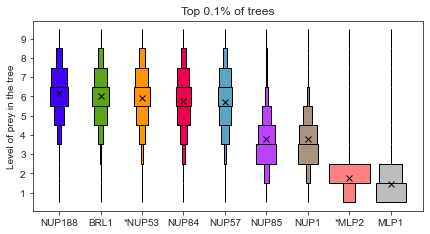

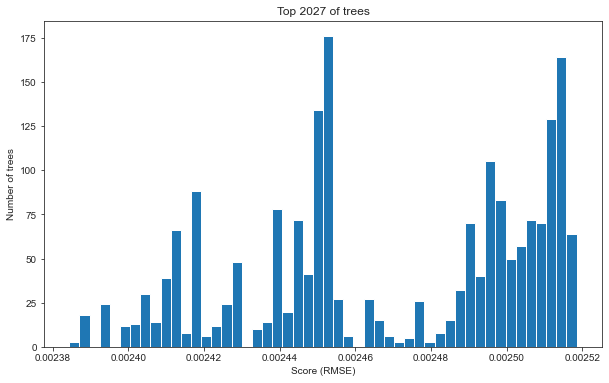

40it [00:01, 20.93it/s]                      


In [24]:
from matplotlib import rc
rc('font',**{'family': 'sans-serif'})
rc('text', usetex=False)

colormap = {"NUP85": "#bd42ff",
            "NUP84": "#ef0052",
            "NUP145C": "#ef0052",
            "NUP133": "#ef0052",
            "*NUP53": "#ff9400",
            #"NUP82": "#5aa518",
            #"NUP159": "#5aa518",
            "NUP57": "#5aa5c6",
            "NUP49": "#5aa5c6",
            "NUP188": "#4200ff",
            "MLP1": "#bdbdbd",
            "*MLP2": "#ff8080",
            "NUP1": "#a99480",
            "BRL1": "#5aa518",
           }

# Generate a single PDF file with all 0.1% top trees (in batches of 40=8x5 per page)
with PdfPages(NEW_RES_DIR / "top_permille_graphs.pdf") as pdf:

    fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
    hist_range = (0, len(preys)+1)
    number_of_bins = len(preys)+1
    binned_data_sets = []

    prey_order = level_df.mean().sort_values(ascending=False).index.tolist()

    for prey in prey_order:
        levels = level_df[prey]
        binned_data_sets.append(np.histogram(levels, range=hist_range, bins=number_of_bins)[0])

    binned_maximums = np.max(binned_data_sets, axis=1)
    x_locations = np.arange(0, len(binned_data_sets)) * np.max(binned_maximums)

    # The bin_edges are the same for all of the histograms
    bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
    centers = 0.5 * (bin_edges + np.roll(bin_edges, 1))[:-1]
    heights = np.diff(bin_edges)

    for x_loc, binned_data, prey in zip(x_locations, binned_data_sets, prey_order):
        lefts = x_loc - 0.5 * binned_data
        ax.barh(0.5+centers, binned_data, height=heights, left=lefts, color=colormap[prey],
                linewidth=1, edgecolor="k")
        ax.plot(x_loc, level_df[prey].mean(), 'kx')

    ax.set_xticks(x_locations)
    ax.set_xticklabels(prey_order)
    ax.set_yticks(range(1, 10))
    ax.set_title("Top 0.1% of trees")
    ax.set_ylabel("Level of prey in the tree")
    ax.set_xlim(-1000, None)
    
    display(fig)
    fig.savefig(NEW_RES_DIR / "tree_level_histogram.pdf")
    pdf.savefig(fig)
    plt.close(fig)
    
    # Plot histogram of all top scores
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    all_scores = [tree_json["score"] for tree_json in res_json["trees"]]
    ax.hist(all_scores, bins=50)
    ax.set_title(f"Top {len(all_scores)} of trees")
    ax.set_xlabel("Score (RMSE)")
    ax.set_ylabel("Number of trees")

    display(fig)
    fig.savefig(NEW_RES_DIR / "tree_score_histogram.pdf")
    pdf.savefig(fig)
    plt.close(fig)
    
    # Plot graphs for all the top trees
    n_trees = 3#len(res_json["trees"])
    n_cols = 5
    n_rows = 8
    with tqdm(total=n_trees) as pbar:
        for i in np.arange(0, n_trees, n_cols*n_rows):
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*6))

            for ax, tree_json in zip(axs.flat, res_json["trees"][i:]):
                tree = AssemblyTree.from_json(tree_json["assembly_tree"])
                tree.plot_tree(ax=ax)
                ax.set_title(f"score = {tree_json['score']:.6f}")
                pbar.update(1)
            pdf.savefig(fig)
            plt.close(fig)

## Generate more statistics using the top 0.1% of trees

In [25]:
tiers = [
    ["NUP57", "NUP84", "*NUP53", "NUP188", "BRL1"],
    ["NUP1", "NUP85", "NUP82"],
    ["MLP1", "*MLP2"],
]

df = pd.read_csv(NEW_RES_DIR / "clusters_ksm_fits_with_Brl1_zerocontrol.csv")

tier_mat_times_data = []
for i1, tier1 in enumerate(tiers):
    for i2, tier2 in enumerate(tiers):
        if i1 == i2+1:
            _df = df[df.bait.isin(tier1) & df.prey.isin(tier2)]
            medi = _df["Maturation time [min]"].median()
            mini = _df.groupby("prey").min()["Maturation time [min]"].median()
            tier_mat_times_data.append((i1, i2, medi, mini))

# estimate the maturation time for MLP1 as the final step in the NPC biogenesis
# by taking the median value across all baits (that are not MLP1).
# since MLP1 is the last protein to join the complex, the maturation time
# should not depend on the bait.

t_mlp1 = df.loc[(df.bait != "MLP1") & (df.prey == "MLP1"), "Maturation time [min]"].median()
tier_mat_times_data.append((2, 2, t_mlp1, t_mlp1))
tier_mat_times_df = pd.DataFrame(data=tier_mat_times_data, columns=["bait tier", "prey tier", "median", "minimum"])

In [26]:
for _, row in tier_mat_times_df.iterrows():
    print(f"Estimated maturation time for step {row['prey tier']+1:.0f}: {row['minimum']:.1f} - {row['median']:.1f} minutes")

Estimated maturation time for step 1: 9.4 - 12.6 minutes
Estimated maturation time for step 2: 23.4 - 23.4 minutes
Estimated maturation time for step 3: 24.3 - 24.3 minutes


<AxesSubplot:xlabel='prey2', ylabel='prey1'>

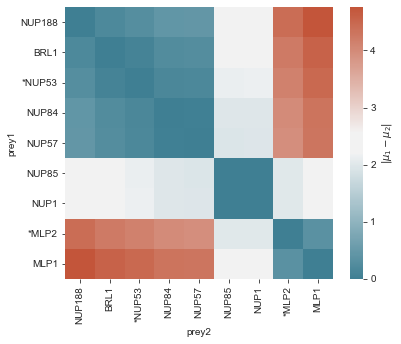

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
diff_data = []
for col1 in prey_order:
    for col2 in prey_order:
        diff_data.append((col1, col2, (level_df[col1] - level_df[col2]).mean()))
diff_df = pd.DataFrame(data=diff_data, columns=["prey1", "prey2", "mean-dist"])
diff_df = diff_df.pivot("prey1", "prey2", "mean-dist")
diff_df = diff_df.loc[prey_order, :]
diff_df = diff_df.loc[:, prey_order]

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(np.abs(diff_df), cmap=cmap, cbar_kws={"label": r"$|\mu_1 - \mu_2|$"}, ax=ax)

<AxesSubplot:>

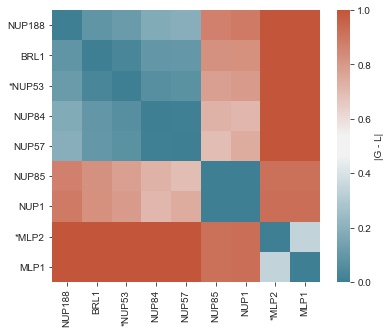

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# heatmap based on |G-L|, i.e. the fraction of times level1 > level2 minus the fraction of times level2 > level1
prey_order = level_df.mean().sort_values(ascending=False).index.tolist()
df = pd.DataFrame(columns=prey_order, index=prey_order, dtype=float)
for prey1, prey2 in itertools.product(prey_order, prey_order):
    levels1 = level_df.loc[0:, prey1]
    levels2 = level_df.loc[0:, prey2]
    df.at[prey1, prey2] = ((levels1 < levels2).sum() - (levels1 > levels2).sum()) / level_df.shape[0]

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(np.abs(df), cmap=cmap, cbar_kws={"label": "|G - L|"}, ax=ax)

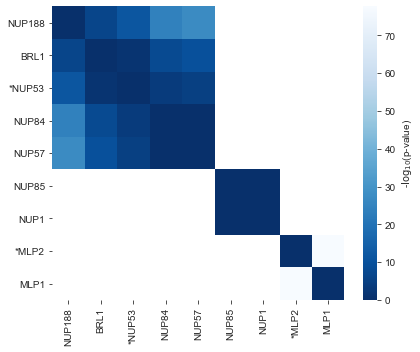

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# calculate p-value of pairwise ranksum tests for the tree-level histograms
prey_order = level_df.mean().sort_values(ascending=False).index.tolist()
df = pd.DataFrame(columns=prey_order, index=prey_order, dtype=float)
for prey1, prey2 in itertools.product(prey_order, prey_order):
    if prey1 == prey2:
        df.at[prey1, prey2] = 1
    else:
        levels1 = level_df[prey1]
        levels2 = level_df[prey2]
        pval = scipy.stats.ranksums(levels1, levels2).pvalue
        if pval < 1e-300:
            df.at[prey1, prey2] = np.nan
        else:
            df.at[prey1, prey2] = pval
sns.heatmap(-np.log10(df), cmap="Blues_r", cbar_kws={"label": r"-$\log_{10}$(p-value)"}, ax=ax)

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "tree_level_pairwise.pdf")